=== Regime: Trend ===


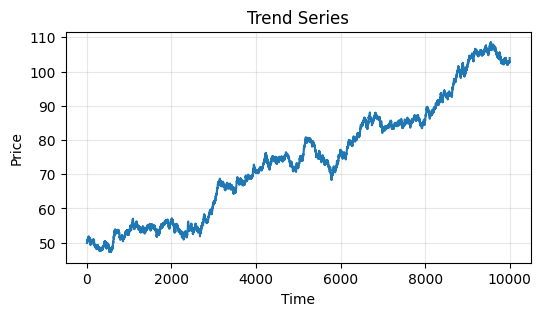

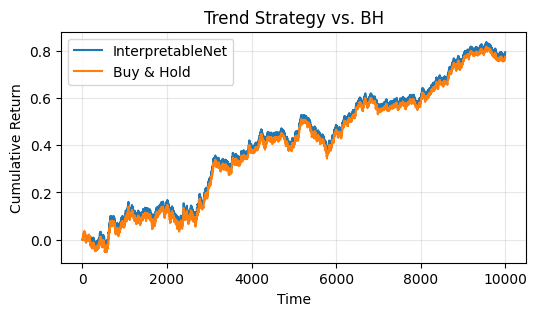

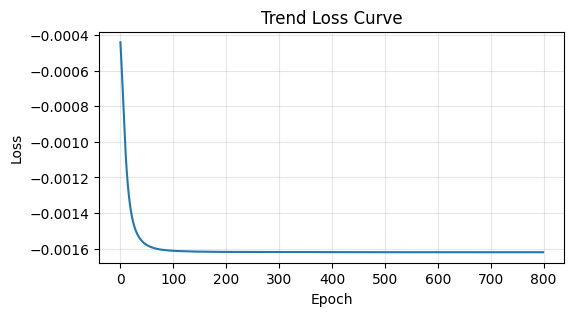

Sharpe ratio: 0.44

=== Regime: Switch ===


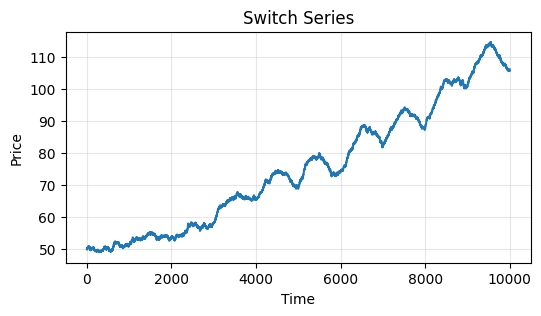

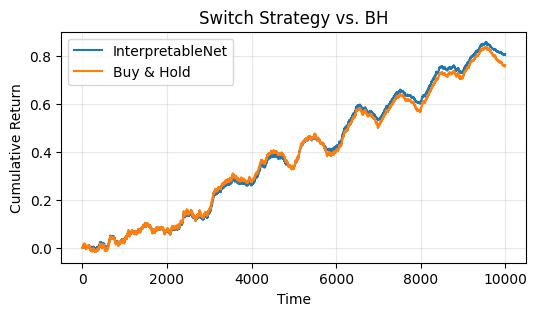

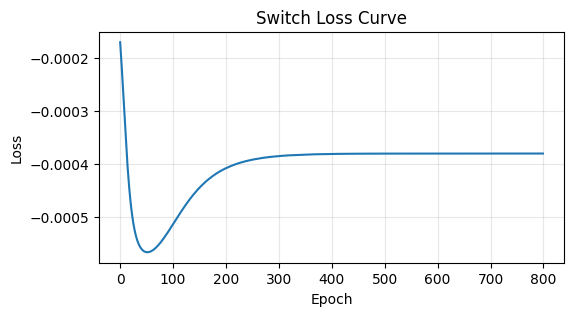

Sharpe ratio: 0.99

=== Regime: Flat ===


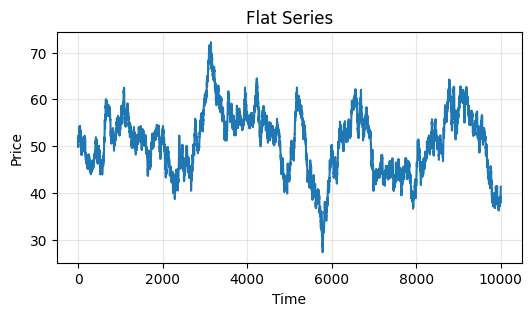

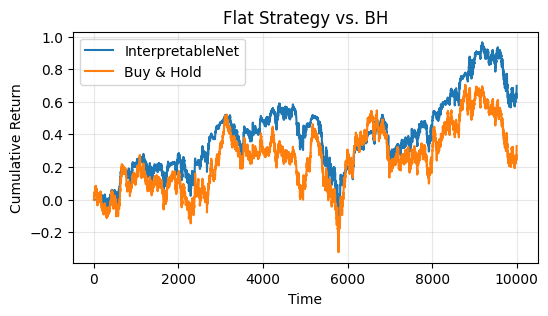

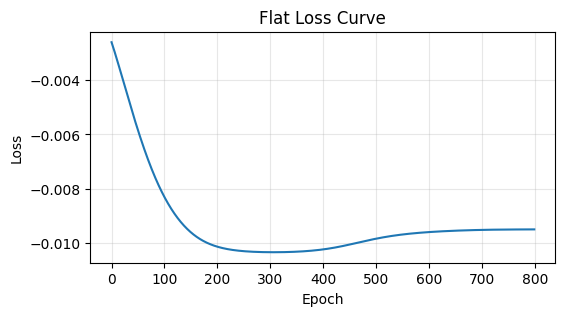

Sharpe ratio: 0.14



,Sharpe
Regime,
Trend,0.441501
Switch,0.986456
Flat,0.140230


In [1]:
# ─── Imports ───────────────────────────────────────────────────────────
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from torch.optim import Adam

from models import TradingPolicy
from train  import prepare_artificial, train_model
from evaluate import get_model_positions  # sliding-window helper

# ─── Hyperparameters ─────────────────────────────────────────────────
window_long, window_short = 200, 50
epochs, lr = 800, 0.001

# ─── Full Pipeline Loop ────────────────────────────────────────────────
results = []
for regime in ['trend','switch','flat']:
    print(f"=== Regime: {regime.title()} ===")

    # 1) Prepare Data
    data = prepare_artificial(regime, window_long, window_short)
    prices, returns = data['prices'], data['returns']

    # 2) Train a new model for this regime
    model = TradingPolicy(window_short, window_long, beta=10.0)
    optimizer = Adam(model.parameters(), lr=lr)
    model, loss_history = train_model(
        model=model,
        data=data,
        optimizer=optimizer,
        is_real=False,
        window_long=window_long,
        epochs=epochs
    )

    # 3) Plot Price Series (Fig 2 panel)
    plt.figure(figsize=(6,3))
    plt.plot(prices.numpy().flatten(), label=regime.title())
    plt.title(f"{regime.title()} Series")
    plt.xlabel("Time"); plt.ylabel("Price")
    plt.grid(alpha=0.3); plt.show()

    # 4) Plot Strategy vs. Buy & Hold (Fig 3)
    pos = get_model_positions(model, prices, window_long)
    cum_strat = torch.cumsum(returns * pos, dim=0).numpy()
    cum_bh    = np.cumsum(returns.numpy())
    plt.figure(figsize=(6,3))
    plt.plot(cum_strat, label='InterpretableNet')
    plt.plot(cum_bh,     label='Buy & Hold')
    plt.title(f"{regime.title()} Strategy vs. BH")
    plt.xlabel("Time"); plt.ylabel("Cumulative Return")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    # 5) Plot Training Loss (Fig 4)
    plt.figure(figsize=(6,3))
    plt.plot(loss_history, label='Training Loss')
    plt.title(f"{regime.title()} Loss Curve")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(alpha=0.3); plt.show()

    # 6) Compute Sharpe
    r = returns * pos
    mu, sigma = r.mean().item(), r.std().item()
    sr = (mu * 252) / (sigma * np.sqrt(252))
    print(f"Sharpe ratio: {sr:.2f}\n")
    results.append((regime.title(), sr))

# ─── Summary Table ─────────────────────────────────────────────────────
df = pd.DataFrame(results, columns=['Regime','Sharpe']).set_index('Regime')
display(df)
